# Vorstellung - Mustererkennung Projekt: GeoLifeClef 2022 (Frankreich)

Projektquelle: [GeoLifeClef 2022 (Kaggle.com)](https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9/overview)

Übersichtsverzeichnis:
1. Übersicht über die Daten (Mikhail Nefedov & Marcus Heimburger)
     1. [Datenbestand](#datenbestand)
     2. [Verteilung der Arten](Wie-sieht-die-Verteilung-der-Arten-aus?)
     3. [Daten der Arten](#Wie-sehen-die-Daten-der-Arten-aus?)
2. [Bewertungsfunktion](#Wie-werden-die-Vorhersagen-der-unterschiedlichen-Algorithmen-bewertet?)
3. [Vorhersagen mithilfe von k-Nächste Nachbarn Klassifikation](#K-Nächste-Nachbarn-Klassifikation) Mikhail Nefedov
4. [Vorhersagen mithilfe von Random Forest Classifier](#Vorhersagen-mit-Random-Forest-Classifier) Marcus Heimburger

In [2]:
## Datenbestand

In [3]:
#Notwendiges Github-Repository für das Projekt:
!rm -rf GLC
!git clone https://github.com/maximiliense/GLC


#Notwendige Imports für das Projekt
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
fatal: destination path 'GLC' already exists and is not an empty directory.


In [4]:
DATA_PATH = Path("./data/")

In [8]:
# 2 Datensäze: Trainingsdatensatz und Testdatensatz
df_obs = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
# Wie sieht der Trainingsdatensatz aus?
df_obs.head()

,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


Trainingsdatensatz besteht aus:
- observation_id : Beobachtungs Id
- latitude : Breitengrad
- longitude : Längengrad
- species_id : Spezies Id (Art, die an dieser Stelle gesichtet wurde)
- subset : Training/Validierung

In [9]:
#Wie sieht der Testdatensatz aus?
df_obs_test.head()

,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


Testdatensatz besteht nur aus Breiten- und Längengrad.

Da uns die tatsächlichen Beobachtungen für den Testdatensatz fehlen (Auswertung in der Kaggle-Competition), greifen wir auf den Validierungsdatensatz zurück und bewerten anhand diesem die Losungsansätze

In [10]:
#Datensätze aufgesplittet auf Training - Validierung - Test
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values
obs_id_test = df_obs_test.index.values

n_obs = len(df_obs)
n_train = len(obs_id_train)
n_val = len(obs_id_val)
n_test = len(obs_id_test)

print(f'Datensatzgröße: {n_obs}')
print(f'Trainingsdatensatzgröße: {n_train} - {n_train / n_obs :.2%} der Beobachtungen')
print(f'Validierungsdatensatzgröße: {n_val} - {n_val / n_obs :.2%} der Beobachtungen')
print(f'Testdatensatzgröße: {n_test}')

Datensatzgröße: 671244
Trainingsdatensatzgröße: 656263 - 97.77% der Beobachtungen
Validierungsdatensatzgröße: 14981 - 2.23% der Beobachtungen
Testdatensatzgröße: 17295


## Wie sieht die Verteilung der Beobachtungen aus?

Für die Region Gironde sind keine Datenpunkte vorhanden. Der Grund ist uns 
nicht bekannt. Der Datensatz basiert unter anderem auf [iNaturalist](https://www.inaturalist.org/). Dort sind Beobachtungen für Gironde da

Text(0.5, 1.0, 'Verteilung der Beobachtungen in Frankreich)')

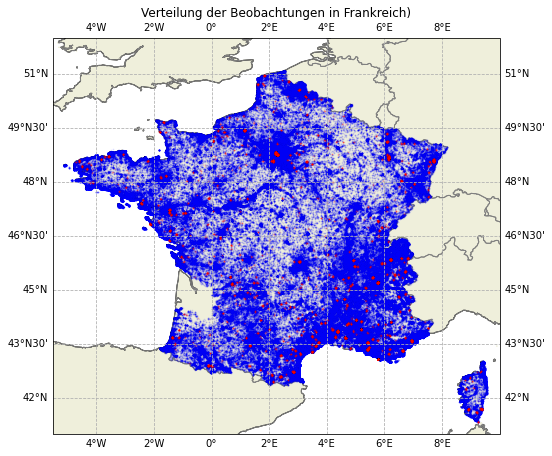

In [13]:
from GLC.plotting import plot_map

def plot_observations_distribution(ax, df_obs, df_obs_test, **kwargs):
    default_kwargs = {
        "zorder": 1,
        "alpha": 0.1,
        "s": 0.5
    }
    default_kwargs.update(kwargs)
    kwargs = default_kwargs
    
    ax.scatter(df_obs.longitude, df_obs.latitude, color="blue", **kwargs)
    ax.scatter(df_obs_test.longitude, df_obs_test.latitude, color="red", **kwargs)

fig = plt.figure(figsize=(8, 8))
ax = plot_map(region="fr")
plot_observations_distribution(ax, df_obs, df_obs_test)
ax.set_title("Verteilung der Beobachtungen in Frankreich)")

## Wie sieht die Verteilung der Arten aus?

Gesamtanzahl an Arten: 4858


(1, 1265.0)

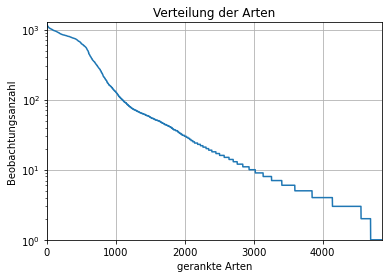

In [15]:
species_value_counts = df_obs["species_id"].value_counts()
print("Gesamtanzahl an Arten: {}".format(len(species_value_counts)))

fig = plt.figure()
ax = fig.gca()

x = np.arange(len(species_value_counts))
ax.plot(x, species_value_counts)

ax.set_yscale("log")

ax.set_xlabel("gerankte Arten")
ax.set_ylabel("Beobachtungsanzahl")
ax.set_title("Verteilung der Arten")

ax.grid()
ax.autoscale(tight=True)
ax.set_ylim(bottom=1)

## Wie sehen die Daten der Arten aus?

In [17]:
#Daten sind in species_details.csv gespeichert
df_species = pd.read_csv(DATA_PATH / "metadata" / "species_details.csv", sep=";")

print("Gesamtzahl an Arten: {}".format(len(df_species)))

print("\nAnzahl an Arten in jedem Reich:")
print(df_species.GBIF_kingdom_name.value_counts())

df_species.head()

Gesamtzahl an Arten: 17037

Anzahl an Arten in jedem Reich:
Plantae     9080
Animalia    7957
Name: GBIF_kingdom_name, dtype: int64


,species_id,GBIF_species_id,GBIF_species_name,GBIF_genus_name,GBIF_family_name,GBIF_kingdom_name
0,0,5356345,Laburnum anagyroides,Laburnum,Fabaceae,Plantae
1,1,2874515,Cucurbita maxima,Cucurbita,Cucurbitaceae,Plantae
2,2,2874569,Cucumis sativus,Cucumis,Cucurbitaceae,Plantae
3,3,3033363,Ranunculus acris,Ranunculus,Ranunculaceae,Plantae
4,4,3034830,Heracleum sphondylium,Heracleum,Apiaceae,Plantae


Begriffsklärung zum besseren Verständnis:
- spezies id: Id der Art
- GBIF: Global Biodiversity Information Facility (Informationen zu Biodiversität)
- GBIF_species_name: Name der Art
- GBIF_genus_name: Name der Gattung
- GBIF_family_name: Name der Familie
- GBIF_kingdom_name: Name des Reiches

weitere Informationen zur biologischen Systematik unter: https://de.wikipedia.org/wiki/Art_(Biologie) 

Einige Arten tauchen in Frankreich nicht auf, da der originale Kaggle-Datensatz auch die USA betrachtet.

## Wie werden die Vorhersagen der unterschiedlichen Algorithmen bewertet?

aus: https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9/overview/evaluation

Die Metrik ist die Top-30 Fehlerrate. Eine Beobachtung $i$ besitzt das label $y_{i}$ für die entsprechende ID der beobachteten Art. Für eine Beobachtung werden 30 IDs als Vorhersage ($\hat{y}_{i,1} , ..., \hat{y}_{i,30}$) eingereicht. 

Top-30 Fehlerrate berechnet sich durch die Formel:

$$ \text{Top-30 Fehlerrate} = \frac{1}{N} \sum \limits _{i=1} ^{N} e_{i} \text{   mit   } e_{i} = 
\begin{cases} 
1 & \text{if } \forall{k} \in {1,...,30}, \hat{y}_{i,k} \neq y_{i} \\ 
0 & \text{ansonsten}
\end{cases}
$$

Formeln zur Berechnung kommen aus dem [GLC](https://github.com/maximiliense/GLC), welches von der Erstellern der GeoLifeCLEF2022 bereitgestellt wurde:

In [19]:
from GLC.metrics import top_30_error_rate, top_k_error_rate_from_sets, predict_top_30_set
from GLC.submission import generate_submission_file

# K-Nächste Nachbarn Klassifikation

In [21]:
y_train = df_obs.loc[obs_id_train]["species_id"].values  #Id der Arten vom Trainingsdatensatz
y_val = df_obs.loc[obs_id_val]["species_id"].values # Id der Arten vom Validierungsdatensatz

X_train_loc = df_obs.loc[obs_id_train][['latitude','longitude']].values #Breitengrad, Längengrad vom Trainingsdatensatz
X_val_loc = df_obs.loc[obs_id_val][['latitude','longitude']].values # Breitengrad, Längengrad vom Validierungsdatensatz

In [22]:
PREDICTION_COUNT = 30

#Nehme die 30 besten Vorhersagen für eine Koordinate
def pred_coord(coord, y):
    arr = y[coord]
    u, count = np.unique(arr, return_counts=True)   # Artenanzahl in Nachbarn
    count_sort_ind = np.argsort(-count)             # Absteigende Sortierung
    return u[count_sort_ind][:PREDICTION_COUNT]     # Auswahl von Prediction Count

#Treffe Vorhersage für ein Array von Koordinaten
def predict_NN(model, X_loc, y):
    distances, indices = model.kneighbors(X_loc)
    predictions = []
    for i in range(len(indices)):
        predictions.append(pred_coord(indices[i],y))
    return np.array(predictions)

In [26]:
x_neighbors = []
y_scores = []

NEIGHBORS_MIN = 100
NEIGHBORS_MAX = 1250

for k_neighbors in range(NEIGHBORS_MIN, NEIGHBORS_MAX, 50):
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(X_train_loc)
    s_pred = predict_NN(nbrs, X_val_loc, y_train)
    score = top_k_error_rate_from_sets(y_val, s_pred)

    x_neighbors.append(k_neighbors)
    y_scores.append(score)

Text(0.5, 1.0, 'Top-30 Fehlerrate für unterschiedliche n (K-Nächste Nachbarn)')

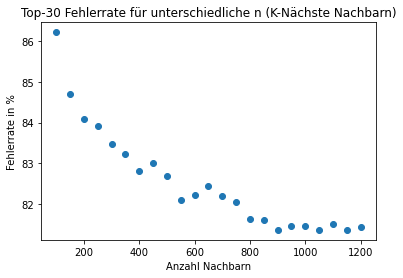

In [27]:
y_scores_percentage = list(map(lambda x: x*100, y_scores))

plt.scatter(x_neighbors, y_scores_percentage)

plt.xlabel("Anzahl Nachbarn")
plt.ylabel("Fehlerrate in %")
plt.title("Top-30 Fehlerrate für unterschiedliche n (K-Nächste Nachbarn)")

Resultat: Wahl von k beeinflusst die Fehlerrate nur geringfügig. Sie schwankt von 81,36 % - 81,64 %

Überlegungen zur Wahl von k: Warum wird ein recht großes k gewählt?

[272 149  66  23  17  13   8   2   1   1   1   1   2   1] [ 1  2  3  4  5  6  7 10 11 12 13 15 16 18]


Text(0, 0.5, 'Anzahl Arten')

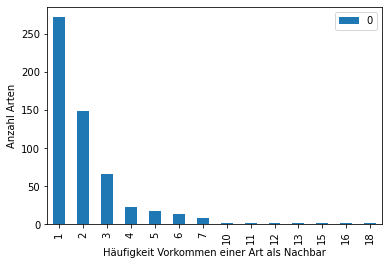

In [25]:
example_location = X_val_loc[100]  # Beispiel Koordinate
example_location = example_location.reshape(1, -1)

distances, indices = nbrs.kneighbors(example_location)  # Rückgabe der Nachbarn
species_ids = y_train[indices]  # Nachbarn als Arten

u, count = np.unique(species_ids, return_counts=True)  # Anzahl Vorkommen der Arten
u, count = np.unique(count, return_counts=True) # (Anzahl an Arten, die nur 1x als Nachbar vorkommen, ...)

print(count, u)
df_count_unique_neighbors = pd.DataFrame(count, u)
ax = df_count_unique_neighbors.plot.bar()
ax.set_xlabel("Häufigkeit Vorkommen einer Art als Nachbar")
ax.set_ylabel("Anzahl Arten")

Aus den 1200 beobachteten Nachbarn tauchen 272 Arten nur einmal auf. 149 Arten treten zweimal auf. Dadurch könnte es bei einem zu kleinem k passieren, dass kaum Arten mehrmals auftreten. Das ist für unsere Vorhersagen nicht gut, wenn unter den Nachbarn alle Arten nur 1-2x vorkommen.